<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [60]:
from datetime import datetime

In [2]:
# Поменяйте на свой путь к данным
#PATH_TO_DATA = '~/capstone_user_identification'
PATH_TO_DATA = 'data/capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [290]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ 
    Функция должна возвращать новый DataFrame.
    Признаки: site1, ... site10, session_timespan, #unique_sites, start_hour, day_of_week и user_id 
    '''
    # инициализация
    y = np.array([0]).reshape(1, 1) # вектор ответов
    data_mod = []    # модифицированный список закодированных сайтов с учетом окна
    data_timestamp = []
    data_timeindex = []
    data_hour = []
    data_weekday = []
        
    # считываем частотный словарь
    with open(site_freq_path, 'rb') as pkl_file:
        freq_vocabulary = pickle.load(pkl_file)
            
    # подготовим пути для обхода и обойдем:
    for path in tqdm_notebook(glob(os.path.join(path_to_csv_files, 'user*.csv'))):
              
        # считаем файл с данными
        data_df = pd.read_csv(path, header=0, index_col=0)
        #data = data_readed['site'].values.copy() # и скопируем его в numpy-массив
        
        # перекодируем site_string в site_id
        data = data_df['site'].apply(lambda x: freq_vocabulary[x][0])
        
        # формируем модифицированные данные с учетом окна для 1 текущего юзера data_mod_user_id
        row = int(data.size / window_size) + 1 if data.size % window_size != 0 \
                                                               else int(data.size / window_size)
        def features(data, row, session_length, window_size):
            data = data.values.reshape(-1, 1)
            # добавим сразу нули
            data = np.vstack((data, np.zeros([session_length, 1])))
            return  [data[w * window_size + sess, 0] for w in range(row) for sess in range(session_length)]   
        
        # работаем с датой-временем
        data_df.index = data_df.index.to_datetime()
        data_df['timestamp'] = data_df.index
        data_df['timestamp'] = data_df['timestamp'].apply(datetime.timestamp)
                
        # формируем и накапливаем блок с временными данными аналогично сайтовому блоку
        data_timestamp_id = features(data_df['timestamp'], row, session_length, window_size)
        data_timestamp.extend(data_timestamp_id)
        
        # формируем и накапливаем данные по часу
        data_hour_id = features(data_df.index.hour, row, session_length, window_size)
        data_hour.extend(data_hour_id)
        
        # формируем и накапливаем данные по weekday
        data_weekday_id = features(data_df.index.weekday, row, session_length, window_size)
        data_weekday.extend(data_weekday_id)        
        
        # сформируем и накопим вектор y "ответов", то есть user_id
        user_id = int(path[-8:-4]) # id пользователя
        col_user_id = np.zeros([1, row]) + user_id # forming columns with user_id
        y = np.hstack((y, col_user_id))
        
    # сформируем признаки site1, ... siteNN
    rows = int(len(data_mod) / session_length)
    
    data_mod = np.array(data_mod)
    data_mod.resize((rows, session_length))
    
    # формируем time_diff (работа со timestamp)
    data_timestamp = np.array(data_timestamp)
    data_timestamp.resize((rows, session_length))
    
    data_hour = np.array(data_hour)
    data_hour.resize((rows, session_length))
    
    data_weekday = np.array(data_weekday)
    data_weekday.resize((rows, session_length))    
    
    data_time_diff = (data_timestamp[:, 1] - data_timestamp[:, 0]).reshape(rows, 1)
    for j in range(2, session_length):
        data_time_diff = np.hstack((data_time_diff, 
                                        (data_timestamp[:, j] - data_timestamp[:, j - 1]).reshape(rows, 1)))
     
    
    
    
    # собираем все вместе
    data_mod = np.hstack((data_mod, data_time_diff))
    
    df = pd.DataFrame(data_mod).applymap(lambda x: x if x >=0 else 0)
    df['session_timespan'] = df[list(range(10, 19))].sum(axis=1)
    df['#unique_sites'] = [np.unique(df[list(range(10))].values[i, :]).shape[0] - 1 if 0 in df[list(range(10))].values[i, :]
                           else np.unique(df[list(range(10))].values[i, :]).shape[0] for i in range(df.shape[0])]
    
    df['start_hour'] = data_hour[:, 0]
    
    df['day_of_week'] = data_weekday[:, 0]
    
    df['target'] = y[0, 1:]
    
    df.columns = feature_names
    
    return df.astype(int)

**немного более компактная реализация, по времени практически то-же самое (46 сек на 10 юзерах против 48 сек)**

In [331]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ 
    Функция должна возвращать новый DataFrame.
    Признаки: site1, ... site10, session_timespan, #unique_sites, start_hour, day_of_week и user_id 
    '''
    # инициализация
    y = np.array([0]).reshape(1, 1) # вектор ответов
    data_mod = []    # модифицированный список закодированных сайтов с учетом окна
    data_timestamp = []
    data_timeindex = []
    data_hour = []
    data_weekday = []
    y = []
        
    # считываем частотный словарь
    with open(site_freq_path, 'rb') as pkl_file:
        freq_vocabulary = pickle.load(pkl_file)
            
    # подготовим пути для обхода и обойдем:
    for path in tqdm_notebook(glob(os.path.join(path_to_csv_files, 'user*.csv'))):
              
        # считаем файл с данными
        data_df = pd.read_csv(path, header=0, index_col=0)
        #data = data_readed['site'].values.copy() # и скопируем его в numpy-массив
        
        # перекодируем site_string в site_id
        data = data_df['site'].apply(lambda x: freq_vocabulary[x][0])
        
        # формируем модифицированные данные с учетом окна для 1 текущего юзера data_mod_user_id
        row = int(data.size / window_size) + 1 if data.size % window_size != 0 \
                                               else int(data.size / window_size)
        
        def features(data, row, session_length, window_size):
            data = data.values.reshape(-1, 1)
            # добавим сразу нули
            data = np.vstack((data, np.zeros([session_length, 1])))
            return  [data[w * window_size + sess, 0] for w in range(row) for sess in range(session_length)]   
        
        def features_one_col(data, row, window_size):
            data = data.values.reshape(-1, 1)
            
            return  [data[w * window_size, 0] for w in range(row)]   
        
        # формируем и накапливаем модифицированный список закодированных сайтов с учетом окна
        data_mod_user_id = features(data, row, session_length, window_size)
        data_mod.extend(data_mod_user_id)
                 
        # работаем с датой-временем
        data_df.index = data_df.index.to_datetime()
        data_df['timestamp'] = data_df.index
        data_df['timestamp'] = data_df['timestamp'].apply(datetime.timestamp)
                
        # формируем и накапливаем блок с временными данными аналогично сайтовому блоку
        data_timestamp_id = features(data_df['timestamp'], row, session_length, window_size)
        data_timestamp.extend(data_timestamp_id)
        
        # формируем и накапливаем данные по часу
        data_hour_id = features_one_col(data_df.index.hour, row, window_size)
        data_hour.extend(data_hour_id)
        
        # формируем и накапливаем данные по weekday
        data_weekday_id = features_one_col(data_df.index.weekday, row, window_size)
        data_weekday.extend(data_weekday_id)        
        
        # сформируем и накопим вектор y "ответов", то есть user_id
        user_id = int(path[-8:-4]) # id пользователя
        col_user_id = list(np.zeros(row) + user_id) # forming columns with user_id
        y.extend(col_user_id)
        
    # сформируем признаки site1, ... siteNN
    rows = int(len(data_mod) / session_length)
    
    data_mod = np.array(data_mod)
    data_mod.resize((rows, session_length))
    
    # формируем time_diff (работа со timestamp)
    data_timestamp = np.array(data_timestamp)
    data_timestamp.resize((rows, session_length))
       
    data_time_diff = (data_timestamp[:, 1] - data_timestamp[:, 0]).reshape(rows, 1)
    for j in range(2, session_length):
        data_time_diff = np.hstack((data_time_diff, 
                                        (data_timestamp[:, j] - data_timestamp[:, j - 1]).reshape(rows, 1)))
     
    
    
    
    # собираем все вместе
    data_mod = np.hstack((data_mod, data_time_diff))
    
    df = pd.DataFrame(data_mod).applymap(lambda x: x if x >=0 else 0)
    df['session_timespan'] = df[list(range(10, 19))].sum(axis=1)
    df['#unique_sites'] = [np.unique(df[list(range(10))].values[i, :]).shape[0] - 1 if 0 in df[list(range(10))].values[i, :]
                           else np.unique(df[list(range(10))].values[i, :]).shape[0] for i in range(df.shape[0])]
    
    df['start_hour'] = data_hour
    
    df['day_of_week'] = data_weekday
    
    df['target'] = y
    
    df.columns = feature_names
    
    return df.astype(int)

**Проверим функцию на игрушечном примере.**

In [332]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

моя реализация

In [333]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


АВТОРСКАЯ реализация

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [338]:
%%time
train_data_10users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                      site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                      feature_names=feature_names, session_length=10)


Wall time: 46 s


In [313]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,9,1,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,15,1,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,15,1,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,17,1,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [299]:
%%time
train_data_150users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                      site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                      feature_names=feature_names, session_length=10)


Wall time: 30min 7s


In [300]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,2,3,1,2,1,3,4,5,1,1,1,4,0,1,0,49,0,57,5,8,4,6
1,3,6,7,4,5,5,8,9,10,10,0,0,26,1,10,73,0,1504,4,1618,8,8,4,6
2,5,11,1,1,1,1,9,5,3,1,1,10,1,5,16,56,1917,0,4,2010,5,8,4,6
3,1,1,12,12,13,12,12,1,14,1,1,0,1,0,118,420,1460,6,0,2006,4,9,4,6
4,1,1,15,1,16,17,16,17,18,15,4,3,0,1,0,1,0,1,0,10,5,9,4,6


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [301]:
new_features_10users = train_data_10users.drop('target', axis=1)
new_features_150users = train_data_150users.drop('target', axis=1)

In [302]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [303]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [304]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [305]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [306]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [339]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [340]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

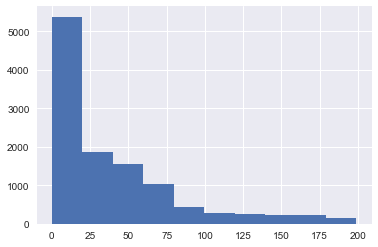

In [343]:
  ''' ВАШ КОД ЗДЕСЬ '''
train_data_10users['session_timespan'][train_data_10users['session_timespan'] < 200].hist()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

In [ ]:
train_data_10users['#unique_sites']  ''' ВАШ КОД ЗДЕСЬ '''

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
     ''' ВАШ КОД ЗДЕСЬ '''

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

In [ ]:
train_data_10users['start_hour'] ''' ВАШ КОД ЗДЕСЬ '''

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
     ''' ВАШ КОД ЗДЕСЬ '''

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

In [ ]:
train_data_10users['day_of_week'] ''' ВАШ КОД ЗДЕСЬ '''

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
     ''' ВАШ КОД ЗДЕСЬ '''

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [ ]:
with open ''' ВАШ КОД ЗДЕСЬ '''

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10_freqs = ''' ВАШ КОД ЗДЕСЬ '''
top10_sites = ''' ВАШ КОД ЗДЕСЬ '''

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [ ]:
sns.barplot ''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

На следующей неделе мы наконец приступим к обучению моделей классификации. 